# Traffic Counting with OpenCV

This Jupyter notebook implements car detection and counting using background subtraction and motion tracking.

### **Video Input and Setup**

In [1]:
import cv2
import numpy as np
from IPython.display import display, clear_output
import PIL.Image
import time
VIDEO = "Traffic_Laramie_1.mp4"

### **Tunable Parameters**
These control detection sensitivity, ROI placement, and tracking thresholds.

In [2]:
# ---- Tunables ----
ROI_FRAC = (0.45, 0.90, 0.10, 0.90)  # (y1, y2, x1, x2) as fractions of H/W
COUNT_LINE_FRAC = 0.55               # y position of count line inside ROI (0=top of ROI, 1=bottom)
N_BASELINE = 90
BLUR_K = 21
DIFF_THRESH = 30
MIN_AREA = 1700
ALPHA_SMOOTH = 0.92
MAX_MATCH_DIST = 60
MAX_MATCH_DIST_STATE1 = 140 
AGE_MAX = 10
AGE_MAX_STATE1 = 30 
WRITE_OUT = True
# ---- New tunables for the L->R then up path ----
VLINE_FRAC = 0.45       # vertical line inside ROI: x = frac*ROI_width
HLINE_FRAC = 0.55       # horizontal line inside ROI: y = frac*ROI_height
ORDER_WINDOW = 290       # max frames allowed between first and second crossing
MIN_SPEED = 0.4         # px/frame to ignore jitter

# Matching / lifecycle
IOU_MIN = 0.10                # first try to match by IoU >= this
DIST_MAX = 80                 # px fallback distance gate (state=0/2)
DIST_MAX_STATE1 = 160         # bigger gate during turn (state=1)
MISS_MAX = 8                  # frames you can miss before deleting track
MISS_MAX_STATE1 = 24          # keep state=1 tracks longer

### **Helper Functions**
These functions handle bounding boxes, IoU, ROI extraction, and preprocessing.

### **bbox_from_cxcywh(cx, cy, w, h)**

Converts a bounding box from center-based format (cx, cy, w, h) to corner format (x1, y1, x2, y2).
This is useful because OpenCV and IoU calculations use top-left and bottom-right corners.

In [3]:
def bbox_from_cxcywh(cx, cy, w, h):
    x1 = cx - w/2; y1 = cy - h/2
    x2 = x1 + w;  y2 = y1 + h
    return (x1, y1, x2, y2)

### **iou(boxA, boxB)**

Calculates the Intersection over Union (IoU) between two bounding boxes.
This metric measures how much two boxes overlap and is used to match detected objects with tracked ones.

In [4]:
def iou(boxA, boxB):
    ax1, ay1, ax2, ay2 = boxA
    bx1, by1, bx2, by2 = boxB
    inter_x1 = max(ax1, bx1); inter_y1 = max(ay1, by1)
    inter_x2 = min(ax2, bx2); inter_y2 = min(ay2, by2)
    iw = max(0.0, inter_x2 - inter_x1); ih = max(0.0, inter_y2 - inter_y1)
    inter = iw * ih
    if inter <= 0: return 0.0
    areaA = (ax2-ax1)*(ay2-ay1); areaB = (bx2-bx1)*(by2-by1)
    return inter / (areaA + areaB - inter + 1e-6)

### **extract_roi(frame)**

Crops a region of interest (ROI) from the frame using ROI_FRAC, which defines the area to analyze.
Returns the ROI image and its offset (to map back to the full frame if needed).

In [5]:
def extract_roi(frame):
    h, w = frame.shape[:2]
    y1, y2, x1, x2 = ROI_FRAC
    Y1, Y2, X1, X2 = int(y1*h), int(y2*h), int(x1*w), int(x2*w)
    return frame[Y1:Y2, X1:X2], (Y1, X1)

### **to_gray_blur(img)**

Converts the ROI to grayscale and applies Gaussian blur to reduce noise before computing differences.
This helps create a smoother mask for motion detection.

In [6]:
def to_gray_blur(img):
    g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.GaussianBlur(g, (BLUR_K, BLUR_K), 0)

### **Main Processing Loop**
The rest of the notebook handles frame-by-frame car detection, tracking, and counting.

### Build Baseline (Median of First N Frames)
This section reads the first `N_BASELINE` frames and builds a background image using the median. This baseline is used to detect motion in subsequent frames.


In [7]:
# ---- Build baseline (median of first N frames) ----
cap = cv2.VideoCapture(VIDEO)
if not cap.isOpened():
    raise RuntimeError(f"Could not open {VIDEO}")

gray_stack = []
while len(gray_stack) < N_BASELINE:
    ok, f = cap.read()
    if not ok:
        break
    roi, _ = extract_roi(f)
    gray_stack.append(to_gray_blur(roi))
if not gray_stack:
    raise RuntimeError("No frames read to build baseline.")
baseline = np.median(np.stack(gray_stack, axis=0), axis=0).astype(np.uint8)

### Reset and Video Setup
Resets the video to the beginning, retrieves FPS and frame dimensions, and sets up the output video writer if enabled.

In [8]:
# Reset to start
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
fps = cap.get(cv2.CAP_PROP_FPS) or 25
w  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h  = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

if WRITE_OUT:
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(VIDEO.replace(".mp4","_counted.mp4"), fourcc, fps, (w, h))



### Tracking + Counting Initialization
Initializes variables to track objects across frames, count cars, and manage unique IDs for each detection.


In [9]:
# ---- Tracking + Counting ----
tracks = []  # each: {'cx','cy','w','h','age','counted','last_cy'}
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
total_count = 0
frame_idx = 0
next_id = 0

### Frame-by-Frame Processing
Main loop: processes each frame to detect motion, update tracking, and count cars that follow the defined left to right then up path.


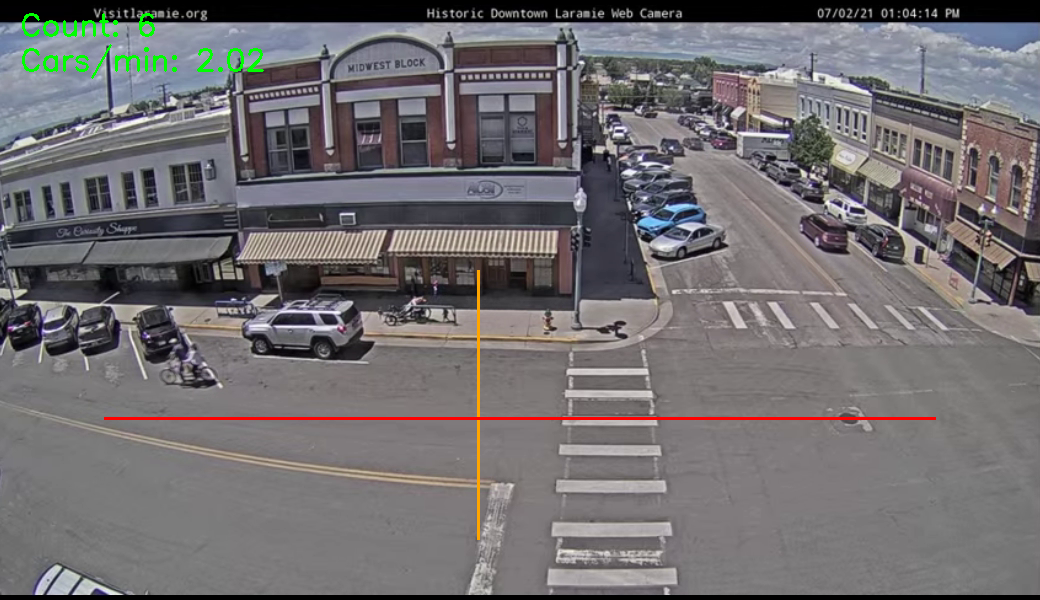

error: OpenCV(4.12.0) /io/opencv/modules/highgui/src/window.cpp:1295: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'


In [10]:
while True:
    # Read the frame and track the number of frames read.
    ok, frame = cap.read()
    # Break out of the loop if there are no more frames to be read.
    if not ok:
        break
    frame_idx += 1

    # Convert the ROI to grayscale and apply the Gaussian blur to reduce noise and smooth the image.
    # to prepare the frame for motion detection
    roi, (offY, offX) = extract_roi(frame)
    g = to_gray_blur(roi)

    # Motion Detection via Background Subtraction
    # Computes the absolute difference from the baseline and applies thresholding and morphology to isolate the moving objects (the cars).

    # Create the difference image by computing the difference between the current frame (g), and the background image.
    delta = cv2.absdiff(g, baseline)
    # Convert the difference image (delta) to a binary mask.
    # Pixels that changed a lot (greater than the DIFF_THRESH) become white (255).
    # The other pixels become black (0), which highlights the moving areas where the pixel values changed.
    _, mask = cv2.threshold(delta, DIFF_THRESH, 255, cv2.THRESH_BINARY)

    # This creates a small elliptical kernal that is 5x5 to clean the mask.
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    # Close is used to fill holes in the detected objects, when the mask of a car has gaps in it.
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    # Open is used to remove noise and reduce false positives.
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  kernel, iterations=1)
    # Dilate is used to expand the white areas, which merges blobs that are close.
    mask = cv2.dilate(mask, kernel, iterations=2)


    # Contour Detection
    # Finds the outlines of detected motion blobs and filters out small ones. Calculates bounding boxes and centers for each.

    # Find Contours finds the outlines of connected white areas.
    # RETR_EXTERNAL retrieves only the outside contours.
    # CHAIN_APPROX_SIMPLE compresses the contour points to save memory.
    # Cnts is a list of contours, each of which is a Numpy array of points.
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Build detection list with boxes (x1,y1,x2,y2) for IoU
    dets = []
    for c in cnts:
        # Contour Area computes the area in pixels of the blob. If it's too small, it's skipped.
        if cv2.contourArea(c) < MIN_AREA: continue
        # Bounding Rect returns a rectangle that surrounds the contour.
        x, y, w2, h2 = cv2.boundingRect(c)
        # Cx and cy are the center of the bounding rectangle and is used for tracking.
        cx, cy = x + w2/2, y + h2/2
        # Dets stores the detection info. Box is used for IoU tracking.
        dets.append({'cx':cx,'cy':cy,'w':w2,'h':h2,'box':(x, y, x+w2, y+h2)})

    # Used_det initializes a list of False values which is the same length as dets.
    # Each element will be set to True if the detection is matched to an existing track,
    # which avoids assigning the same detection to more than one track.
    used_det = [False]*len(dets)

    # Track Matching with IoU
    # Matches current detections to existing tracks by using "Intersection-over-Union" (IoU). Prioritizes armed (state=1) and older tracks.

    # build proposals (ti, di, iou)
    proposals = []
    # Ti is the index of the track, and tr is the track object, which is a dict with fields like cx, cy, w and h.
    for ti, tr in enumerate(tracks):
        # Convert the tracked object's center and size format into the corner format for the IoU comparison.
        tbox = bbox_from_cxcywh(tr['cx'], tr['cy'], tr['w'], tr['h'])
        # Looks for the detection (dets) with the highest IoU to this track.
        best = (-1, 0.0)
        for di, d in enumerate(dets):
            # Skips detections that are already matched.
            if used_det[di]: continue
            j = iou(tbox, d['box'])
            # Stores the index di and the best IoU score.
            if j > best[1]: best = (di, j)
        # Only suggest a match if the IoU is greater than or equal to the threshold (IOU_MIN).
        if best[0] != -1 and best[1] >= IOU_MIN:
            # Each proposal is a tuple. Ti is the track index, best[0] is the detection index, best[1] is the IoU score,
            # 1 if tr.get('state',0)==1 else 0 prioritizes the state=1 tracks, and age favors older tracks.
            proposals.append((ti, best[0], best[1], 1 if tr.get('state',0)==1 else 0, tr.get('age',0)))
    
    # Sorts proposals by state == 1, then higher IoU, then older track.
    proposals.sort(key=lambda x: (x[3], x[2], -x[4]), reverse=True)
    
    matched_tracks = {}
    matched_dets = set()
    # Loops through the sorted proposals.
    for ti, di, _, _, _ in proposals:
        # Skips any tracks or detections that are already matched.
        if ti in matched_tracks or di in matched_dets: continue
        # Adds the match to matched_tracks, which is a map of the track index to the detection index,
        # matched_dets, which is the set of detection indices that are already used
        # and used_det = True, which flags the detection as assigned so it's skipped.
        matched_tracks[ti] = di
        matched_dets.add(di); used_det[di] = True

    # Update Matched Tracks
    # Smooths the position, size and other parameters of matched tracks by using exponential averaging.

    # Ti is the track index from tracks and di is the detection index from dets.
    for ti, di in matched_tracks.items():
        # Tr is the dict for the track.
        tr = tracks[ti]
        # D is the matching detection.
        d  = dets[di]
        # This is exponential smoothing. It blends the old value (tr) with the new value (d) using
        # new value = alpha * old + (1 - alpha) * new.
        # ALPHA_SMOOTH is used to allow the old value to dominate slightly, which reduces jitter and
        # smooths the motion of the tracked object. 
        a = ALPHA_SMOOTH
        tr['cx'] = a*tr['cx'] + (1-a)*d['cx']
        tr['cy'] = a*tr['cy'] + (1-a)*d['cy']
        tr['w']  = a*tr['w']  + (1-a)*d['w']
        tr['h']  = a*tr['h']  + (1-a)*d['h']
        # Age is set to 0 to reset the frames since it was last seen.
        tr['age'] = 0
        # Misses is set to 0 to reset how many frames it has been undetected.
        tr['misses'] = 0

    # Creates a set of track indices so the fallback logic can skip matched tracks.
    matched_t = set(matched_tracks.keys())

    # Fallback Distance Matching
    # For unmatched tracks, try associating them to unmatched detections based on Euclidian pixel distance.

    # 2) Fallback distance matching for still-unmatched tracks/detections
    # Loop through all tracks.
    for ti, tr in enumerate(tracks):
        # Skip any that were already matched by IoU.
        if ti in matched_t: continue
        # Sets a maximum allowed distance in pixels for matching. If the track has crossed the first line and is in state 1,
        # it gets a larger tolerance (DIST_MAX_STATE1).
        gate = DIST_MAX_STATE1 if tr.get('state',0)==1 else DIST_MAX
        # Search through all the unmatched detections.
        best, bestd = -1, 1e18
        for di, d in enumerate(dets):
            if used_det[di]: continue
            dx = tr['cx'] - d['cx']; dy = tr['cy'] - d['cy']
            # Compute the squared distance between the centers of the track and the detection.
            dist2 = dx*dx + dy*dy
            if dist2 < bestd:
                # Keep the closest detection found (best) and the squared distance (bestd).
                bestd, best = dist2, di

        # If the best detection found is within the allowed distance (gate), smoothly update the track position and size,
        # reset age and misses and set the detection as used.
        if best != -1 and bestd <= gate*gate:
            d = dets[best]
            used_det[best] = True
            a = ALPHA_SMOOTH
            tr['cx'] = a*tr['cx'] + (1-a)*d['cx']
            tr['cy'] = a*tr['cy'] + (1-a)*d['cy']
            tr['w']  = a*tr['w']  + (1-a)*d['w']
            tr['h']  = a*tr['h']  + (1-a)*d['h']
            tr['age'] = 0
            tr['misses'] = 0
        else:
            # If no detection was close enough, then increment how long it's been active (age) and how long its been unmatched (
            tr['age'] += 1
            tr['misses'] += 1

    # Increment the age of all tracks.
    for tr in tracks:
        tr['age'] = tr.get('age', 0) + 1

    # Create New Tracks
    # Creates new tracks for unmatched detections, but not if they are too close to existing tracks.

    # 3) Create tracks for any leftover detections
    # Loops through each detection (d) and its index (di).
    for di, d in enumerate(dets):
        # Skips detections that were already matched to existing tracks.
        if used_det[di]: continue
        # Duplicate is a flag to mark whether the detection is too close to any existing track.
        duplicate = False
        # Loop through existing tracks.
        for tr in tracks:
            # Calculates the IoU between the detection and the track. A higher IoU threshold is used if the track is
            # in state == 1.
            thr = 0.55 if tr.get('state',0)==1 else 0.35
            # If the overlap is too high, it's probably the same object.
            if iou(bbox_from_cxcywh(tr['cx'],tr['cy'],tr['w'],tr['h']), d['box']) > thr:
                # Set as a duplicate and skip it.
                duplicate = True; break
            # Compute the squared distance between the detection and the track center.
            dx, dy = tr['cx'] - d['cx'], tr['cy'] - d['cy']
            # If the distance is too small, it's probably the same object.
            r2 = 50*50 if tr.get('state',0)==1 else 90*90
            if dx*dx + dy*dy < r2:
                duplicate = True; break
        # If either the IoU or the distance was too close to an existing track, then skip creating a new track.
        if duplicate:
            continue

        # Otherwise, create a new track.
        tracks.append({
            'id': next_id, 'cx': d['cx'], 'cy': d['cy'], 'w': d['w'], 'h': d['h'],
            'age': 0, 'misses': 0, 'counted': False,
            'last_cx': d['cx'], 'last_cy': d['cy'], 'state': 0, 't1': -1
        })
        next_id += 1

    # Delete Stale Tracks
    # Removes tracks that haven’t been matched for too long, with longer tolerance for the turning cars (state=1).

    # 4) Prune with state-aware miss limits (keep turn-state longer)
    pruned = []
    for t in tracks:
        lim = MISS_MAX_STATE1 if t.get('state',0)==1 else MISS_MAX
        # Only keep the track if it has missed fewer frames than the allowed limit.
        if t['misses'] < lim:
            pruned.append(t)
    # Replace the original tracks list with only the active tracks.
    tracks = pruned

    # left to Right then Up Counting Logic
    # Implements the two-step condition to count cars:
    # 1. Crosses the vertical line from left to right.
    # 2. Then crosses horizontal line upward within a time window.

    # ---- Left to right then up crossing logic + overlay ----
    roi_h, roi_w = roi.shape[0], roi.shape[1]
    vx = int(VLINE_FRAC * roi_w)
    hy = int(HLINE_FRAC * roi_h)
    
    # ensure debug-safe defaults
    for tr in tracks:
        tr.setdefault('last_cx', tr['cx'])
        tr.setdefault('last_cy', tr['cy'])
        tr.setdefault('state', 0)   # 0: none, 1: passed vertical left to right, 2: counted
        tr.setdefault('t1', -1)
        tr.setdefault('counted', False)
        tr.setdefault('id', id(tr)) # unique ID
    
    for tr in tracks:
        # Px, py is the previous position.
        px, py = tr['last_cx'], tr['last_cy']
        # Cx, cy is the current position.
        cx, cy = tr['cx'], tr['cy']
    
        # crossed if prev and curr are on opposite sides
        vx_cross = (px - vx) * (cx - vx) < 0
        hy_cross = (py - hy) * (cy - hy) < 0

        # Make sure the car is going left to right and upwards.
        sx = cx - px
        sy = cy - py
    
        # Step 1: must cross vertical line going L->R first
        if tr['state'] == 0 and vx_cross and sx > MIN_SPEED:
            tr['state'] = 1
            # Set the time that it happened.
            tr['t1'] = frame_idx
    
        # Step 2: within window, cross horizontal line going UP
        if tr['state'] == 1:
            if frame_idx - tr['t1'] > ORDER_WINDOW:
                tr['state'], tr['t1'] = 0, -1   # timeout: reset
            elif hy_cross and sy < -MIN_SPEED and not tr['counted']:
                total_count += 1
                tr['counted'] = True
                tr['state'] = 2
    
        # remember for next frame
        tr['last_cx'], tr['last_cy'] = cx, cy

    # Draw Guide Lines and Overlay Tracks
    # Draws vertical and horizontal lines, track bounding boxes, and track state on each frame.

    # draw guide lines
    cv2.line(roi, (vx, 0), (vx, roi_h-1), (0,165,255), 2)  # vertical (orange line)
    cv2.line(roi, (0, hy), (roi_w-1, hy), (0, 0, 255), 2)  # horizontal (red line)
    
    # overlay each track's state (green box; orange if state=1; blue dot if counted)
    for t in tracks:
        x = int(t['cx'] - t['w']/2)
        y = int(t['cy'] - t['h']/2)
        color = (0,255,0)
        if t['state'] == 1: color = (0,165,255)
        cv2.rectangle(roi, (x, y), (x + int(t['w']), y + int(t['h'])), color, 2)
        if t['counted']:
            cv2.circle(roi, (int(t['cx']), int(t['cy'])), 4, (255,0,0), -1)
        cv2.putText(roi, f"id{str(t['id'])[-3:]} s{t['state']}",
                    (x, max(0, y-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)

    
    # ---- draw the two lines (add to your drawing block) ----
    cv2.line(roi, (vx, 0), (vx, roi_h-1), (0, 165, 255), 2)  # vertical: orange
    cv2.line(roi, (0, hy), (roi_w-1, hy), (0, 0, 255), 2)    # horizontal: red

    # paste ROI back
    frame[offY:offY+roi.shape[0], offX:offX+roi.shape[1]] = roi

    # HUD: totals + cars/min
    elapsed_s = frame_idx / fps
    cpm = total_count / (elapsed_s/60) if elapsed_s > 0 else 0.0
    cv2.putText(frame, f"Count: {total_count}", (20, 35),
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,0), 2)
    cv2.putText(frame, f"Cars/min: {cpm:.2f}", (20, 70),
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,0), 2)

    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_pil = PIL.Image.fromarray(img_rgb)
    clear_output(wait=True)
    display(img_pil)
    time.sleep(0.0005)
    if WRITE_OUT: out.write(frame)

cap.release()
if WRITE_OUT: out.release()
cv2.destroyAllWindows()
print(f"Done. Total cars: {total_count}")